# Ngram Twitter Bargraph
This notebook takes you though the steps to create a bargraph of ngrams (unigrams, bigrams, or trigrams) from tweets in either .csv or .json format.

###  Before we begin
Before we start, you will need to have set up a [Carbonate account](https://kb.iu.edu/d/aolp) in order to access [Research Desktop (ReD)](https://kb.iu.edu/d/apum). You will also need to have access to ReD through the [thinlinc client](https://kb.iu.edu/d/aput). If you have not done any of this, or have only done some of this, but not all, you should go to our [textPrep-Py.ipynb](https://github.com/cyberdh/Text-Analysis/blob/master/textPrep-Py.ipynb) before you proceed further. The textPrep-Py notebook provides information and resources on how to get a Carbonate account, how to set up ReD, and how to get started using the Jupyter Notebook on ReD.   

### Run CyberDH environment
The code in the cell below points to a Python environment specificaly for use with the Python Jupyter Notebooks created by Cyberinfrastructure for Digital Humanities. It allows for the use of the different packages in our notebooks and their subsequent data sets.

##### Packages
- **sys:** Provides access to some variables used or maintained by the interpreter and to functions that interact strongly with the interpreter. It is always available.
- **os:** Provides a portable way of using operating system dependent functionality.

#### NOTE: This cell is only for use with Research Desktop. You will get an error if you try to run this cell on your personal device!!

In [1]:
import sys
import os
sys.path.insert(0,"/N/u/cyberdh/Carbonate/dhPyEnviron/lib/python3.6/site-packages")
os.environ["NLTK_DATA"] = "/N/u/cyberdh/Carbonate/dhPyEnviron/nltk_data"

### Include necessary packages for notebook 

Python's extensibility comes in large part from packages. Packages are groups of functions, data, and algorithms that allow users to easily carry out processes without recreating the wheel. Some packages are included in the basic installation of Python, others created by Python users are available for download.

In your terminal, packages can be installed by simply typing `pip install nameofpackage --user`. However, since you are using ReD and our Python environment, you will not need to install any of the packages below to use this notebook. Anytime you need to make use of a package, however, you need to import it so that Python knows to look in these packages for any functions or commands you use. Below is a brief description of the packages we are using in this notebook:   

- **textblob:** Library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more. 

- **nltk:** Platform for building Python programs to work with human language data.

- **re:** Provides regular expression matching operations similar to those found in Perl.

- **string:** contains a number of useful constants and classes, as well as some deprecated legacy functions that are also available as methods on strings.

- **pandas:** An open source, BSD-licensed library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

- **glob:** Finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

- **json:** Allows for handling of data in JSON format.

- **zipfile:** Allows for handling of zipfiles.

- **math:** Provides access to the mathematical functions defined by the C standard.

- **matplotlib:** A Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

In [2]:
from textblob import TextBlob
from nltk.corpus import stopwords
import re
import string
import pandas as pd
import glob
import json
import zipfile
import math

import matplotlib.pyplot as plt

%matplotlib inline

### Set needed variables
This is where you will make some decisions about your data and set the necessary variables. We are doing this so you will not need to make changes in the code further down.

First, we need to decide if we want our code to read all the files in a directory or just a single file. If we want all the files in a directory then we set `source` equal to `"*"`. This means 'all' and will be added to the file type later in the code. If you want a single file change `"*"` to the file name without the ".csv" or ".json" at the end. So if you have a file named "myFile.csv" you would set `source` equal to `"myFile"` without the ".csv".

Next we need to specify what file type our data is saved as. Generally when dealing with Twitter data it will be in either ".json" or ".csv" format. For this reason our notebook will only read in ".csv" or ".json" files. The variable `fileType` is where you choose either ".csv" or ".json" for your `fileType`. So it should look like `fileType = ".csv"` or `fileType = ".json"`.

The `nltkStop` is where you determine if you want to use the built in stopword list provided by the NLTK package. They provide stopword lists in multiple languages. If you wish to use this then set `nltkStop` equal to **True**. If you do not, then set `nltkStop` equal to **False**.

The `customStop` variable is for if you have a dataset that contains additional stopwords that you would like to read in and have added to the existing `stopWords` list. You do **NOT** need to use the NLTK stopwords list in order to add your own custom list of stopwords. **NOTE: Your custom stopwords file needs to have one word per line as it reads in a line at a time and the full contents of the line is read in and added to the existing stopwords list.** If you have a list of your own then set `customStop` equal to **True**. If you do not have your own custom stopwords list then set `customStop` equal to **False**.

The `ng` variable (short for ngram) is where you determine if you want a unigram (basically a word frequency count), a bigram (most common 2 word pairs), or a trigram (most common three word phrases). This will be used in the code further down.

The `stopLang` variable is to choose the language of the nltk stopword list you wish to use. It is currently set to `"english"`. If you need a different language, simply change `"english"` to the anglicized name of the language you wish to use (e.g. "spanish" instead of "espanol" or "german" instead of "deutsch").

The variable `encoding` is where you determine what type encoding to use (ascii, ISO-8850-1, utf-8, etc...). We have it set to utf-8 at the moment as we have found it is less likely to have any problems. However, errors do occur, but the encoding errors rarely impact our results and it causes the Python code to exit. So instead of dealing with unhelpful errors we ignore the ones dealing with encoding by assigning `'ignore'` to the `errors` variable.

The `stopWords = []` is an empty list that will contain the final list of stop words to be removed form your dataset. What ends up in the list depends on whether you set `nltkStop` and/or `customStop` equal to **True** or **False** and if you add any additional words to the list.

The `cleanText` variable is another empty list. This is where your document(s) will reside later.

The `ngramList` variable is another empty list and is where your resulting ngrams will reside. 

In [3]:
source = "*"
fileType = ".json"
nltkStop = True
customStop = True
ng = 2
stopLang = "english"
encoding = "UTF-8"
errors = "ignore"
stopWords = []
cleanText = []
ngramList = []

#### File paths
Here we are saving different file paths as variables that we need in our code. We again do this so you will not need to make as many changes to the code later. 

First we use the `os` package above to find our `['HOME']` directory using the `environ` function. This will work for any operating system, so if you decide to try this out on your personal computer instead of ReD, the `homePath` variable will still be the path to your 'home' directory, so no changes are needed.

Next, we combine the `homePath` file path with the folder names that lead to where our data is stored. Note that we do not use any file names yet, just the path to the folder. This is because we may want to read in all the files in the directory, or just one, or we may need to access a file in this directory, but need to navigate to another folder to access other data. There are options below for doing both. We save the path as a variable named `dataHome`.

Now we add the `homePath` file path to other folder names that lead to a folder where we will want to save any output generated by this code. We again will change the file names for the output in the appropriate cells down below. We save this file path as the variable `dataResults`.

Finally, we use an 'if...else' statement to determine what file path we assign to the variable `dataRoot`. If we chose ".csv" for our `fileType` above then `dataRoot` points to where our ".csv" data is stored. If we chose ".json" for `fileType`, then it points to where our ".json" data is stored.

In [4]:
homePath = os.environ['HOME']
dataHome = os.path.join(homePath, "Text-Analysis-master", "data")
dataResults = os.path.join(homePath, "Text-Analysis-master", "Output")
if fileType == ".csv":
    dataRoot = os.path.join(dataHome, "twitter", "CSV", "parkland")
else:
    dataRoot = os.path.join(dataHome, "twitter", "JSON")

### Stopwords
If you set `nltkStop` equal to **True** above then this will add the nltk stopwords list to the empty list named `stopWords`. You should already have chosen your language above, so there is no need to do that here.

If you wish to add additional words to the `stopWords` list, add the word in quotes to the list in `stopWords.extend(['the', 'words', 'you', 'want', 'to', 'add'])`.

In [5]:
# NLTK Stop words
if nltkStop is True:
    stopWords.extend(stopwords.words(stopLang))
    
    stopWords.extend(['xo_karmin_ox', 'neveragain', 'davidhogg111', 'emma4change'])

#### Add own stopword list

Here is where your own stopwords list is added if you selected **True** in "customStop" above. Here you will need to change the folder names and file name to match your folders and file. Remember to put each folder name in quotes and in the correct path order, always putting the file name including the file extension ('.txt') last.

In [6]:
if customStop is True:
    stopWordsFilepath = os.path.join(dataHome, "twitterStopword.txt")

    with open(stopWordsFilepath, "r",encoding = 'utf-8') as stopfile:
        stopWordsCustom = [x.strip() for x in stopfile.readlines()]

    stopWords.extend(stopWordsCustom)

### Functions
We need to create a few functions in order to calculate and create a bargraph. Any time you see `def` that means we are *DE*claring a *F*unction. The `def` is usually followed by the name of the function being created and then in parentheses are the parameters the function requires. After the parentheses is a colon, which closes the declaration, then a bunch of code below which is indented. The indented code is the program statement or statements to be executed. Once you have created your function all you need to do in order to run it is call the function by name and make sure you have included all the required parameters in the parentheses. This allows you to do what the function does without having to write out all the code in the function every time you wish to perform that task.

#### Text Cleaning
This function does some text cleaning for us and requires the parameter: text (as in what text are you cleaning).

Now we come to the statements to be executed. First we lowercase the text or else 'Love' and 'love' will be counted as two different words, so we make them all 'love'. Next we remove URLs by removing any text that starts with 'http' and ending with a space. Then we split the text into individual words. Next we remove any empty space, digits, stopwords, and punctuation. Finally, we return a list of cleaned words.

In [7]:
def textClean(text):
    
    text = text.strip().lower()
    
    tweets = re.sub(r"http\S+", "", text)
    
    tokens = re.split(r'\W+', tweets )
    
    # remove empty string
    tokens = [t for t in tokens if t]
    
    # remove digits
    tokens = [t for t in tokens if not t.isdigit()]
    
    # built-in stop words list
    tokens = [t for t in tokens if t not in stopWords]
        
    # remove punctuation
    puncts = list(string.punctuation)
    puncts.append('--')

    tokens = [t for t in tokens if t not in puncts]

    return tokens

### Unzip files

Here we are unzipping files. Since twitter data can be rather large it is often necessary to compress it into a '.zip' file in order to upload it to places such as GitHub. For this reason, we have setup some code to go in and automatically extract all the items in a compressed '.zip' file so you do't have to and so you don't get errors later. If the data is not in a '.zip' file there is no need to worry, it will not give an error if there are no files ending in '.zip' in your directory.

You should not need to make any changes as we use the same variables containing our file paths as above, so if you need to make adjustments to the file paths, you need to make them there, specifcally to the `dataRoot` variable.

In [8]:
direct = dataRoot
allZipFiles = glob.glob(os.path.join(dataRoot, "*.zip"))
for item in allZipFiles:
    fileName = os.path.splitext(direct)[0]
    zipRef = zipfile.ZipFile(item, "r")
    zipRef.extractall(fileName)
    zipRef.close()
    os.remove(item)

### Reading in .csv files

If you chose `".csv"` as your `fileType` up above, then the code below reads in ".csv" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".csv" file depending on what you chose for `source` above. 

Once we have read in the ".csv" file using the Pandas `read_csv` function, we need to concatenate the ".csv" files if there are multiple. Because of this it is important that your ".csv" files have and identical column count and each column has identical header names or you will get errors. If you have a single ".csv" file then you should be fine for this step. We assign this process to the variable `cc_df` so we can use it later.

Now we convert our `cc_df` to a pandas dataframe. This allows for easier manipulation of the data in the next step.

The last line is where you will name the column you wish to convert to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. Here we are converting the column labeled `['text']` to a list. If you wished to convert the first column to a list the code would look like this: `tweets = cc_df[0].values.tolist()`. Notice the number is 0 and not 1. This is because Python begins counting at 0.  

In [9]:
if fileType == ".csv":
    all_files = glob.glob(os.path.join(dataRoot, source + fileType))     
    df_all = (pd.read_csv(f, engine = "python") for f in all_files)
    cc_df = pd.concat(df_all, ignore_index=True)
    cc_df = pd.DataFrame(cc_df, dtype = 'str')
    tweets = cc_df['text'].values.tolist()
    content = '\n'.join(tweets)
    cleanTokens = textClean(content)

    print('Finished tokenizing text {}\n'.format(all_files))

### Reading in JSON files

If you chose `".json"` as your `fileType` up above, then the code below reads in ".json" files and saves the contents to a dataframe using the Pandas package. It will read in either an entire directory or a single ".json" file depending on what you chose for `source` above. 

Once we have read in the ".json" file we need to append the ".json" files if there are multiple. Because of this it is important that your ".json" files have identical keys or you will get errors. If you have a single ".json" file then you should be fine for this step. 

Next we append the contents to our empty `tweets=[]` list we created above. Then we convert our tweets list to a dataframe so we can more easily manipulate the data. Each key from the ".json" content is converted to a header in the dataframe and the values associated with that key now become rows in the corresponding column.

In the last line we now convert one column in our dataframe to a list. In between the square brackets you can either put the column header name with quotes around the name, or you can put the column number counting from left to right and starting with 0 instead of 1. Here we are converting the column labeled `['text']` to a list. If you wished to convert the first column to a list the code would look like this: `tweets = df[0].tolist()`. Notice the number is 0 and not 1. This is because Python begins counting at 0.

In [10]:
if fileType == ".json":
    for filename in glob.glob(os.path.join(dataRoot, source + fileType)):
        with open(filename, 'r', encoding = encoding, errors = errors) as jsonData:
            tweets = []
            for line in jsonData:
                tweets.append(json.loads(line))
    df = pd.DataFrame(tweets)
    data = df['text'].tolist()
    content = '\n'.join(data)
    cleanTokens = textClean(content)

    print('Finished tokenizing text {}\n'.format(filename))

Finished tokenizing text /N/u/klosteda/Carbonate/Text-Analysis-master/data/twitter/JSON/part-m-00000.json



No changes needed here. This just converts our text to a str object so we can find ngrams later.

In [11]:
cleanText = ' '.join(cleanTokens)

### Find Ngrams

We use the textblob package to get ngrams. We use the `ng` variable we created earlier to determine if we are interested in unigrams, bigrams, or trigrams. There should be no reason to make changes here.

In [12]:
blob = TextBlob(cleanText)

if ng == 1: 
    nGrams = blob.ngrams(n=1)
if ng == 2:
    nGrams = blob.ngrams(n=2)
if ng == 3:
    nGrams = blob.ngrams(n=3)

Now we are converting our ngrams to a list which we can then put into a dataframe to be turned into a bargraph.

In [13]:
for wlist in nGrams:
   ngramList.append(' '.join(wlist))

Now we make our dataframe. You won't need to make changes to this code.

In [14]:
df = pd.DataFrame(ngramList)
dfCounts = df[0].value_counts()
countsDF = pd.DataFrame(dfCounts)
countsDF.reset_index(inplace = True)
df_C = countsDF.rename(columns={'index':'ngrams',0:'freq'})
df_C['ngrams'] = df_C['ngrams'].astype(str)
dfNG = df_C.sort_values('freq', ascending = False)

Now lets see what our dataframe looks like. If you want to see more, just change the number in parentheses.

In [15]:
dfNG.head(10)

,ngrams,freq
0,blame governmentshutdown,3693
1,cspan blame,2962
2,governmentshutdown history,2893
3,history cspan,1280
4,government shutdown,773
5,day governmentshutdown,750
6,governmentshutdown cspan,737
7,governmentshutdown shutdown,660
8,due governmentshutdown,659
9,shutdown governmentshutdown,616


### Plot our bargraph

#### First set variables
Before we run the cell below, make sure the variables in the beginning of the cell are set correctly. The `n` variable should have a number assigned to it that is the number of ngrams you wish to plot in your graph. 

Next we name the output '.svg' file produced by the code below. Right now the name is a generic `"ngramTopTenTwitter.svg"` but you may wish to change it to something that matches your data.

Then we set our file format. We assign this format to the variable `fmt`. Make sure the `fmt` matches the file type assigned to the `outputFile` variable.

Now we set our dpi. The `dpi` variable gives the desired resolution of our output image.

Then we determine at what angle we want the x tick labels to be. The angle can be anywhere from 0 to 360. We assign this number to the variable `angle`. 

Next, we need to give our graph a title. We assign the title to the variable `title`.

Then, we need to choose some color(s) for our graph. First we choose the bar colors. This is currently set so each bar has it's own color. If you choose to do this know that the colors in the list will repeat in the order you have them if you have more data points than you have colors in your list. The other option is to list only one color and make the bars all the same color. Either way, we assign our color selection as the variable `color`. Then we choose the color for our x axis and y axis labels. We assign our chosen color to the variable `labCol`.

Lastly, we assign a list of ngram stopwords to the variable `ngramStop`. We do this because with ngrams there may be specific ngrams we want removed, but we don't necessarily want to just remove the individual words that make up the ngram. For example, I may wish to remove the ngram 'love love', but I do not want to just remove 'love' as it may be part of other ngrams that are important to my analysis.

#### Ngram stopwords

Now that we're done with the variables, we will remove the ngram stopwords in our `ngramStop` variable from our dataframe.

#### Plot

Finally, we plot our bargraph. Any changes you might wish to make should be in the `# Variables` section of the cell, so you should not need to make changes here. Just plot your bargraph of ngrams!

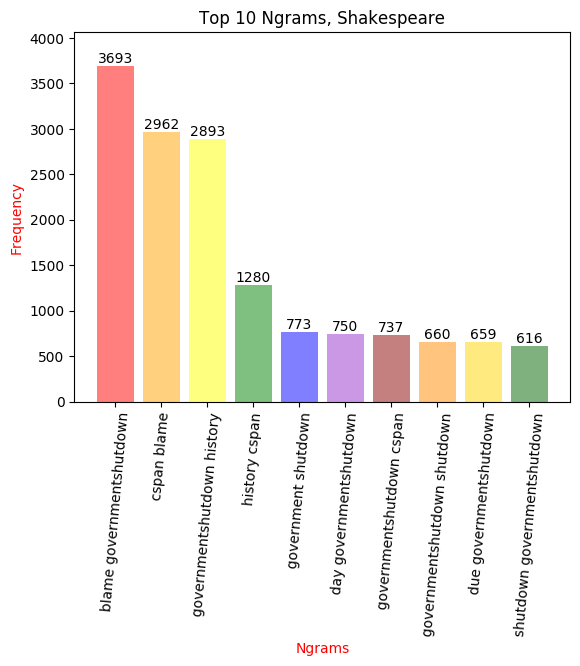

In [19]:
# Variables
n = 10
outputFile = "ngramTopTenTwitter.svg"
fmt = 'svg'
dpi = 300
angle = 85
title = 'Top 10 Ngrams, Shakespeare'
color = ['red','orange', 'yellow', 'green', 'blue','darkorchid', 'darkred', 'darkorange','gold', 'darkgreen']
labCol = 'red'
ngramStop = ["parkland shooter","parkland students", "kidding forgetting", "forgetting come", "2a nra"]

# Ngram Stopwords
text = dfNG[~dfNG['ngrams'].isin(ngramStop)]
dfTN = text[0:n]

# Plot
plt.rcdefaults()

plt.bar(dfTN['ngrams'], dfTN['freq'], align = 'center', alpha = 0.5, color = color)
    

        
plt.xticks(dfTN['ngrams'])
plt.xticks(rotation = angle)
        
xlabel = plt.xlabel('Ngrams')
xlabel.set_color(labCol)
ylabel = plt.ylabel('Frequency')
ylabel.set_color(labCol)
    
high = max(dfTN['freq'])
low = 0
    
plt.ylim(low, math.ceil(high + 0.1 * (high - low)))
    
for xpos, count in zip(dfTN['ngrams'], dfTN['freq']):
    
    plt.text(x = xpos, y = count + 1, s = str(count), ha = 'center', va = 'bottom')

plt.title(title)
 
plt.savefig(os.path.join(dataResults, outputFile), format = fmt, dpi = dpi, bbox_inches = 'tight')
    
plt.show()

## VOILA!!